<a href="https://colab.research.google.com/github/dimmu/notebook-collection/blob/master/SUMO_RevKL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This code reproduces the reverse-KL experiments of SUMO.

Arxiv: https://arxiv.org/abs/2004.00353

Check out our ICLR page and 5min video presentation here: https://iclr.cc/virtual/poster_SylkYeHtwr.html

In [0]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Log scale: values of z <= 0 have been masked


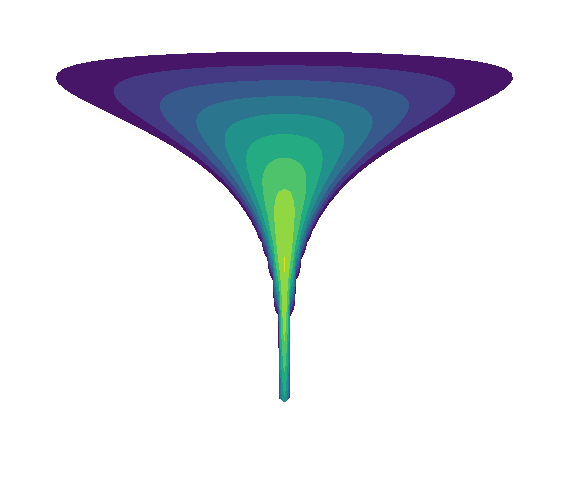

In [0]:
# The target distribution
def log_density_funnel(x):
    x1, x2 = x[:, 0], x[:, 1]
    x2_logdensity = normal_logprob(x2, 0, np.log(1.35))
    x1_logdensity = normal_logprob(x1, 0, x2)
    return x2_logdensity + x1_logdensity


def normal_logprob(z, mean, log_std):
    mean = mean + torch.tensor(0.)
    log_std = log_std + torch.tensor(0.)
    c = torch.tensor([math.log(2 * math.pi)]).to(z)
    inv_sigma = torch.exp(-log_std.to(z))
    tmp = (z - mean.to(z)) * inv_sigma
    return -0.5 * (tmp * tmp + 2 * log_std + c)


# Visualization code
def plot_isocontours(
        ax, func, xlimits=[-9, 9], ylimits=[-6, 3], numticks=101, alpha=1.0, cmap=plt.get_cmap('viridis'),
        logplot=True, device='cpu'
):
    x = np.linspace(*xlimits, num=numticks)
    y = np.linspace(*ylimits, num=numticks)
    X, Y = np.meshgrid(x, y)
    pts = torch.from_numpy(np.concatenate([np.atleast_2d(X.ravel()), np.atleast_2d(Y.ravel())]).T).float().to(device)
    zs = torch.exp(func(pts)).detach().cpu().numpy()
    Z = zs.reshape(X.shape)
    if logplot:
        ax.contourf(X, Y, Z, alpha=alpha, levels=2**np.linspace(-8, -1, 10), cmap=cmap, norm=LogNorm())
    else:
        ax.contourf(X, Y, Z, alpha=alpha, cmap=cmap)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlim(xlimits)
    ax.set_ylim(ylimits)


func = log_density_funnel
fig = plt.figure(figsize=(8, 7), facecolor='white')
ax = fig.add_subplot(111, frameon=False)
plot_isocontours(ax, func)
plt.tight_layout()

The task is to fit this distribution shown above. Since we can evaluate this density, the reverse-KL is a suitable objective.

$\mathbb{E}_{p_\theta(x)} [\log p_\theta(x) - \log p^*(x)] $

where we will be using a latent variable model for $p_\theta(x)$

$p_\theta(x) = \int_z p(x|z) p(z)$

and estimate its log-density $\log p_\theta(x)$ using IWAE or SUMO.

In [0]:
# A tail-modified distribution defined on the positive integers, where P(n >= k) = 1 / k

N = 100  # position where tail distribution changes.

k = np.arange(1, N + 1)
p = 1 / k - 1 / (k + 1)
p[-1] = 1 - sum(p[:-1])


def pN_sample():
    sample = np.random.choice(k, p=p)
    if sample == k[-1]:
        sample = k[-1] + np.random.geometric(0.1) - 1
    return sample


def pN_cumulative_reverse_cdf(n_samples):
    rcdf = 1. / torch.arange(1., N)
    rcdf_tail = 1. / N * geometric_cumulative_reverse_cdf(n_samples - N + 1, 0.1)
    return torch.cat([rcdf, rcdf_tail])


def geometric_cumulative_reverse_cdf(n_samples, prob):
    cumu_samples = torch.arange(1, n_samples + 1).float()
    return (1. - torch.tensor(prob).to(cumu_samples))**(cumu_samples - 1)

In [0]:
class LatentVariableModel(nn.Module):

    def __init__(self, z_dim, n_samples=1):
        super().__init__()
        self.z_dim = z_dim
        self.n_samples = n_samples

        self.encoder = nn.Sequential(
            nn.Linear(2, 200),
            nn.Tanh(),
            nn.Linear(200, z_dim * 2),
        )
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 200),
            nn.Tanh(),
            nn.Linear(200, 4),
        )

        self.rcdf = pN_cumulative_reverse_cdf(500)

    def sample(self, batchsize, device):
        z = torch.randn(batchsize, self.z_dim).to(device)
        return self.decoder(z)
    
    def _encode_decode(self, xs, n_samples=None):
        batchsize = xs.shape[0]
        n_samples = n_samples if n_samples is not None else self.n_samples

        # batchsize , h_dim
        h = self.encoder(xs).view(batchsize, self.z_dim * 2)

        # batchsize x n_samples , h_dim
        q_params = h.unsqueeze(1).expand(batchsize, n_samples, self.z_dim * 2).reshape(batchsize * n_samples, self.z_dim, 2)
        mean, log_std = tuple(t_.squeeze(-1) for t_ in q_params.split(1, -1))

        z_samples = torch.randn_like(mean) * torch.exp(log_std) + mean
        logqz_x = normal_logprob(z_samples, mean, log_std).sum(-1)

        # batchsize, n_samples , z_dim
        z_samples = z_samples.view(batchsize, n_samples, self.z_dim)
        logqz_x = logqz_x.view(batchsize, n_samples)

        decoder_output = self.decoder(z_samples.view(batchsize * n_samples, self.z_dim))
        decoder_output = decoder_output.view(batchsize, n_samples, *decoder_output.shape[1:])
        xs = xs.unsqueeze(1).expand(batchsize, n_samples, *xs.shape[1:])

        logpx_z = observation_logprob(xs, decoder_output).sum(-1)
        logpz = normal_logprob(z_samples, 0., 0.).sum(-1)
        return logpx_z  + logpz - logqz_x

    def iwae(self, xs, n_samples=None):
        batchsize = xs.shape[0]
        n_samples = n_samples if n_samples is not None else self.n_samples

        log_weights = self._encode_decode(xs, n_samples)
        log_weights = log_weights.view(batchsize, n_samples)
        iwae = torch.logsumexp(log_weights, 1) - np.log(n_samples)
        return iwae

    def sumo(self, xs, n_samples=None):
        """Trains using an unbiased objective for log p_theta(x).
        The encoder log q_phi(x) is tasked with minimizing the variance of this estimator.
        """
        batchsize = xs.shape[0]
        n_exact_samples = n_samples if n_samples is not None else self.n_samples
        n_samples = pN_sample()
        tot_samples = n_exact_samples + n_samples

        log_weights = self._encode_decode(xs, tot_samples)
        log_weights = log_weights.view(batchsize, tot_samples)

        # Computes IWAE(1), ..., IWAE(k)
        with torch.no_grad():
            cum_max = cumulative_max(log_weights, dim=1)  # (bs, K)

        cum_max_aug = cum_max.unsqueeze(2).expand(-1, -1, tot_samples)  # (bs, K, K)
        log_weights_aug = log_weights.unsqueeze(1).expand(-1, tot_samples, -1)
        diff = log_weights_aug - cum_max_aug
        tri_ind = np.triu_indices(tot_samples, 1)
        diff[(slice(None),) + tri_ind] = -np.inf

        cum_iwae = cum_max + torch.logsumexp(diff, -1) - torch.arange(1, tot_samples + 1).to(log_weights).log()[None]

        # Compute delta_k, partition into exact and estimated terms.
        residual_terms = cum_iwae[:, n_exact_samples:] - cum_iwae[:, n_exact_samples - 1:-1]

        # Weights 1/P(n >= k).
        residual_weights = 1. / self.rcdf[:n_samples][None]
        unbiased_residual = torch.sum(residual_terms[:, :n_samples] * residual_weights.to(cum_iwae), 1)
        ub_logpx = cum_iwae[:, n_exact_samples - 1] + unbiased_residual
        return ub_logpx


def observation_logprob(samples, decoder_output):
    mean, log_std = torch.split(decoder_output, 2, dim=-1)
    return normal_logprob(samples, mean, log_std)


def cumulative_max(X, dim=-1):
    out = X.clone()
    if dim < 0:
        dim += X.dim()
    leading_indices = (slice(None),) * dim
    n_iters = X.size(dim)
    for idx in range(1, n_iters):
        out[leading_indices + (idx,)] = torch.max(out[leading_indices + (idx - 1,)], X[leading_indices + (idx,)])
    return out


def compute_gradients(loss, *params, retain_graph=False, create_graph=False):
    grads = torch.autograd.grad(loss, params, retain_graph=retain_graph, create_graph=create_graph, allow_unused=True)
    for p, g in zip(params, grads):
        if g is not None:
            p.grad = g.detach()
    if create_graph:
        return grads

In [0]:
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val


def lvm_log_density(samples):
    logps = []
    for xs in torch.split(samples, 100, dim=0):
        logps.append(lvm.iwae(xs, n_samples=400))
    return torch.cat(logps, dim=0)


# Training loop.
def training_loop(lvm, optimizer, batchsize, alg, device):

    fig = plt.figure(figsize=(8, 7), facecolor="white")
    ax = fig.add_subplot(111, frameon=False)

    loss_meter = RunningAverageMeter(0.97)
    enc_gradnorm_meter = RunningAverageMeter(0.97)
    dec_gradnorm_meter = RunningAverageMeter(0.97)

    for itr in range(1, 5001):

        optimizer.zero_grad()

        # Sample from q(x).
        decoder_output = lvm.sample(batchsize, device)
        mean, log_std = decoder_output[:, :2], decoder_output[:, 2:]
        samples = torch.randn_like(mean) * torch.exp(log_std) + mean

        logp = log_density_funnel(samples).mean()

        if alg == "sumo":
            # Compute unbiased log q(x).
            # This also accumulates gradients for decoder params to maximize log q(x),
            # and encoder params to minimize Var(logq(x)).
            logq = lvm.sumo(samples)
            compute_gradients(torch.mean(logq), *lvm.decoder.parameters(), retain_graph=True)
            compute_gradients(torch.mean(logq**2), *lvm.encoder.parameters())

            # Maximize log p(x).
            logp.mul(-1.0).backward()
        elif alg == "iwae":
            logq = lvm.iwae(samples).mean()
            revkl = logq - logp
            revkl.backward()

            # Ensure we always perform posterior inference when using IWAE.
            for p in lvm.encoder.parameters():
                p.grad = -p.grad
        else:
            raise ValueError(f"Unknown algorithm {args.alg}")

        enc_gradnorm = torch.nn.utils.clip_grad.clip_grad_norm_(lvm.encoder.parameters(), 100)
        dec_gradnorm = torch.nn.utils.clip_grad.clip_grad_norm_(lvm.decoder.parameters(), 1e100)
        optimizer.step()

        revkl = logq.mean() - logp

        if revkl.item() < -10.0:
            print("Terminated training as estimated KL is too negative.")
            break

        loss_meter.update(revkl.item())
        enc_gradnorm_meter.update(enc_gradnorm.item())
        dec_gradnorm_meter.update(dec_gradnorm.item())

        if itr % 50 == 0:
            print(itr, loss_meter.avg, enc_gradnorm_meter.avg, dec_gradnorm_meter.avg, flush=True)

    print("Training finished.")
    plot_isocontours(ax, lvm_log_density, device=device, logplot=True)
    plt.show()

## Training Reverse KL with IWAE.

Here we ensure that the encoder is still being trained to perform approximate posterior inference,

$\max_\phi \mathbb{E}_{p_\theta(x)} [\text{IWAE}(x)]$

while the decoder (model) is trained using the reverse-KL objective

$\min_\theta \mathbb{E}_{p_\theta(x)} [\text{IWAE}(x) - \log p^*(x)]$

50 6.1944570987897976 3.020605638351845 197.58422037213612
100 3.8786169974011466 1.747815810758278 104.02529822694018
150 2.2399836718722534 1.399625664977658 43.60686088090188
200 2.065947285104052 1.2969766560781568 43.62339811648662
250 1.6162065276447217 1.2317049024824511 27.86630126532143
300 2.052954352283106 1.2231297547502338 59.634103016632224
350 1.6440230294002232 1.2018828466579132 37.68787547342861
400 1.311128091144363 1.2033484443129545 22.147867020985025
450 1.1769707013047133 1.2116020618707806 17.463559156045825
500 1.1326078813004337 1.1908855257808295 20.051948414865013
550 1.0008388887189281 1.1784604569454826 12.657412816668183
600 1.0433052230541295 1.1916781692729763 16.25140483522026
650 0.8948099222544682 1.1949144267263658 9.173856578151538
700 0.9070555089078117 1.173946842380255 10.423778992388028
750 0.8250811954910309 1.170292288539123 7.10009317186968
800 0.8164105813290308 1.1751551716485182 6.431470809398141
850 0.784338653971615 1.1536963607750412 5

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Log scale: values of z <= 0 have been masked


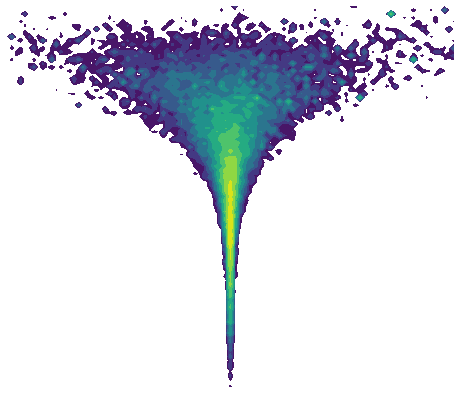

In [0]:
z_dim = 20
batchsize = 200
n_samples = 15  # expected num samples is this value + 5
lr = 1e-4
alg = "iwae"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

lvm = LatentVariableModel(z_dim, n_samples)
optimizer = optim.RMSprop(lvm.parameters(), lr=lr, eps=1e-3)

training_loop(lvm, optimizer, batchsize, alg, device)

## Training Reverse KL with SUMO.

Here we train the encoder to minimize variance of the SUMO estimator. Since SUMO is unbiased, we can simply minimize the second moment.

$\nabla_\phi \text{Var}[\text{SUMO}] = \mathbb{E} [ \nabla_\phi \text{SUMO}^2 ]$

50 2.801695814095969 62.54248194714756 110.36480474025866
100 1.931475285579506 35.90435645971274 52.720619797210695
150 1.5593365612936534 106.57307977753766 31.50247183880162
200 1.4523659742541175 75.32846229892364 25.91119754071538
250 1.1070313438599602 37.690981948995905 15.096949117938202
300 1.0687144238362918 427.56842010050855 13.827930639300664
350 0.9672042909302874 106.71855623508111 11.619156532032884
400 0.9027332059277027 79.02749084980931 9.437322727998644
450 0.9272738037723033 43.08301197048498 10.516215124698961
500 0.8456584575113664 40.67828832108756 7.705356601395233
550 0.841246223891887 37.80011644701445 8.651951330115834
600 0.8111303460234255 22.608069538615535 6.838637268323591
650 0.7820912444495267 15.33210300284435 6.067330487270346
700 0.87379655647644 49.75998859064057 10.530192604864258
750 0.7698695894525452 28.806606663828234 5.914721258224419
800 0.7410436405676218 21.49006753866279 5.231908843186069
850 0.7650281231987034 247.80357145451174 6.15429

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Log scale: values of z <= 0 have been masked


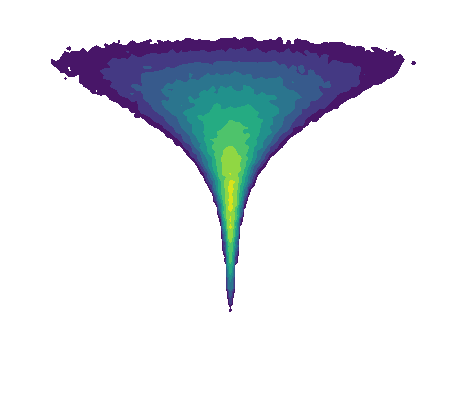

In [0]:
z_dim = 20
batchsize = 200
n_samples = 10  # expected num samples is this value + 5
lr = 1e-4
alg = "sumo"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

lvm = LatentVariableModel(z_dim, n_samples)
optimizer = optim.RMSprop(lvm.parameters(), lr=lr, eps=1e-3)

training_loop(lvm, optimizer, batchsize, alg, device)